<a href="https://colab.research.google.com/github/Daivar/Deep_Learning_Models/blob/main/YOLO_COCO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time
import cv2
import os

!git clone https://github.com/pjreddie/darknet
!wget https://pjreddie.com/media/files/yolov3.weights

Cloning into 'darknet'...
remote: Enumerating objects: 5943, done.
remote: Total 5943 (delta 0), reused 0 (delta 0), pack-reused 5943
Receiving objects: 100% (5943/5943), 6.37 MiB | 13.17 MiB/s, done.
Resolving deltas: 100% (3927/3927), done.
--2022-02-10 10:28:20--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  71.4MB/s    in 3.5s    

2022-02-10 10:28:23 (67.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [2]:
print(cv2.__version__)

4.1.2


In [3]:
# load the COCO class labels our YOLO model was trained on
labelsPath = "./darknet/data/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")
# initialize a list of colors to represent each possible class label
np.random.seed(42)
# colors to draw bounding boxes
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [4]:
# derive the paths to the YOLO weights and model configuration
weightsPath = "./yolov3.weights"
configPath = "./darknet/cfg/yolov3.cfg"

# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [5]:
!wget https://raw.githubusercontent.com/kalyco/yolo_detector/master/images/baggage_claim.jpg


--2022-02-10 10:30:10--  https://raw.githubusercontent.com/kalyco/yolo_detector/master/images/baggage_claim.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55444 (54K) [image/jpeg]
Saving to: ‘baggage_claim.jpg’

baggage_claim.jpg   100%[===================>]  54.14K  --.-KB/s    in 0.008s  

2022-02-10 10:30:10 (6.36 MB/s) - ‘baggage_claim.jpg’ saved [55444/55444]



In [6]:
# load our input image and grab its spatial dimensions
image = cv2.imread("baggage_claim.jpg")

In [7]:
(H, W) = image.shape[:2]
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))
print(len(layerOutputs))

[INFO] YOLO took 2.490101 seconds
3


In [8]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [9]:
confid = 0.5
threshold = 0.2

# loop over each of the layer outputs
for output in layerOutputs:
	# loop over each of the detections
	for detection in output:
		# extract the class ID and confidence (i.e., probability) of the current object detection
		scores = detection[5:]
		classID = np.argmax(scores)
		confidence = scores[classID]
		# filter out weak predictions by ensuring the detected
		# probability is greater than the minimum probability
		if confidence > confid:
			# scale the bounding box coordinates back relative to the
			# size of the image, keeping in mind that YOLO actually
			# returns the center (x, y)-coordinates of the bounding
			# box followed by the boxes' width and height
			box = detection[0:4] * np.array([W, H, W, H])
			(centerX, centerY, width, height) = box.astype("int")
			# use the center (x, y)-coordinates to derive the top and
			# and left corner of the bounding box
			x = int(centerX - (width / 2))
			y = int(centerY - (height / 2))
			# update our list of bounding box coordinates, confidences,
			# and class IDs
			boxes.append([x, y, int(width), int(height)])
			confidences.append(float(confidence))
			classIDs.append(classID)

In [10]:
len(boxes)

15

In [11]:
# apply non-maxima suppression to suppress weak, overlapping bounding boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

In [12]:
len(idxs)

11

In [13]:
idxs

array([[ 0],
       [ 3],
       [ 7],
       [ 5],
       [ 4],
       [10],
       [12],
       [ 8],
       [14],
       [ 1],
       [ 2]], dtype=int32)

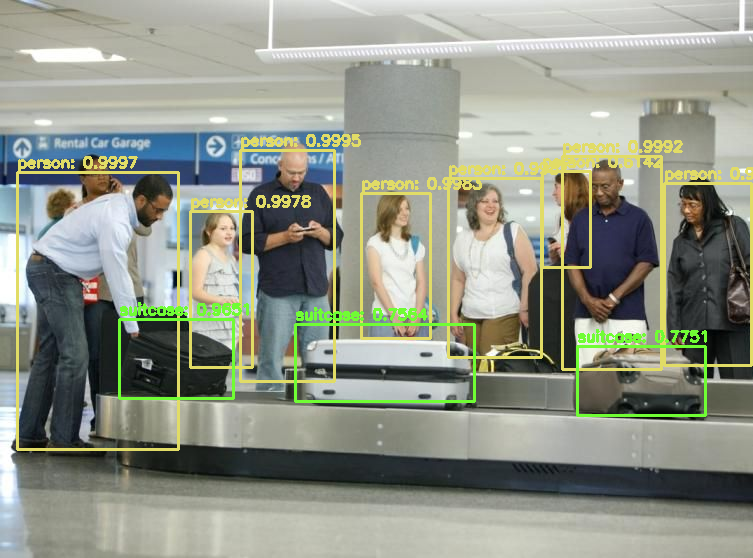

In [14]:
from google.colab.patches import cv2_imshow

# ensure at least one detection exists
if len(idxs) > 0:
	# loop over the indexes we are keeping
	for i in idxs.flatten():
		# extract the bounding box coordinates
		(x, y) = (boxes[i][0], boxes[i][1])
		(w, h) = (boxes[i][2], boxes[i][3])
		# draw a bounding box rectangle and label on the image
		color = [int(c) for c in COLORS[classIDs[i]]]
		cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
		text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
		cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
# show the output image
cv2_imshow(image)
# cv2.imshow(COLORS, image) TODO ???
# cv2.waitKey(0)